In [1]:
#imports
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter

from sklearn import preprocessing

In [2]:
#load the data
df = pd.read_csv(r'TrainData_PA_cleansed')
df

,rent,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,...,SFR,Triplex,garage_no,garage_yes,pool_no,pool_yes,fireplace_no,fireplace_yes,patio_no,patio_yes
0,2400,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,1,0,0,1,1,0,0,1
1,995,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,0,1,0,1,0,1,0,1
2,1740,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,0,1,0,1,1,0,1,0
3,675,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,0,1,0,1,0,1,0,1
4,1300,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,1,0,0,1,0,1,0,1,0,1
5,1025,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,1,0,0,1,0,1,0,1
6,1025,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,1,0,0,1,0,1,0,1
7,1025,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,1,0,1,0,0,1,0,1,0,1
8,795,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,1,0,0,1,0,1,0,1
9,925,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,0,1,0,1,0,1,0,1


##### We have highest rent in the year : 1960

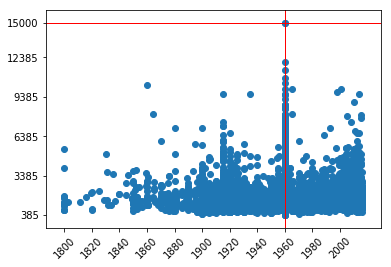

In [3]:
#let us plot the hot in mind
year = list(df[df.rent == df['rent'].max()]['yearbuilt'])[0]
#y_ticks = (df.rent.min() + df.rent.max())/4
y_ticks = list(np.arange(df.rent.min(), df.rent.max(), 3000))
y_ticks.append(df.rent.max())

fig, ax = plt.subplots()
ax.axhline(df['rent'].max(),color='r',lw=1)
ax.axvline(year,color='r',lw=1)
plt.xticks(np.arange(df.yearbuilt.min(), df.yearbuilt.max()+1, 20),rotation=45)

plt.yticks(y_ticks)


plt.scatter(df['yearbuilt'],df['rent'])
plt.show()

##### * Till 1900 the data are not so reliable or stable.  i.e. it has to fluctuation when observed in the plot and hence there is no regular pattern there.
##### * And Also, 1960 highest rent seems like out of the blue. Someone really got lucky or it is an data entry error. It is a outlier for sure.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15515 entries, 0 to 15514
Data columns (total 47 columns):
rent                     15515 non-null int64
cemetery_dist_miles      15515 non-null float64
nationalhighway_miles    15515 non-null float64
railline_miles           15515 non-null float64
starbucks_miles          15515 non-null float64
walmart_miles            15515 non-null float64
hospital_miles           15515 non-null float64
physician_dist_miles     15515 non-null float64
dentist_dist_miles       15515 non-null float64
opt_dist_miles           15515 non-null float64
vet_dist_miles           15515 non-null float64
farmers_miles            15515 non-null float64
bed                      15515 non-null int64
bath                     15515 non-null int64
halfbath                 15515 non-null int64
sqft                     15515 non-null int64
yearbuilt                15515 non-null int64
lotsize                  15515 non-null float64
Census_MedianIncome      15515 non-null

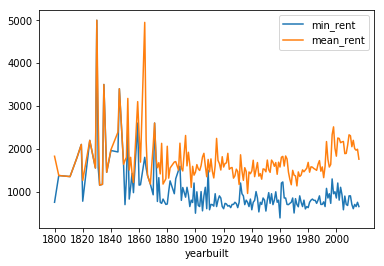

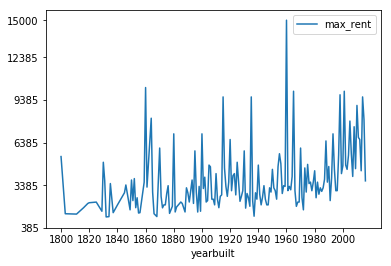

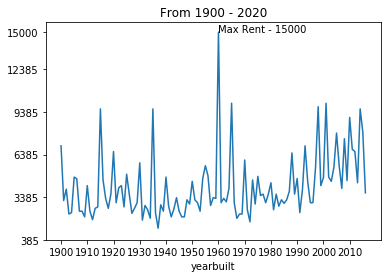

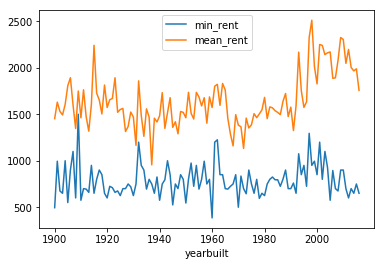

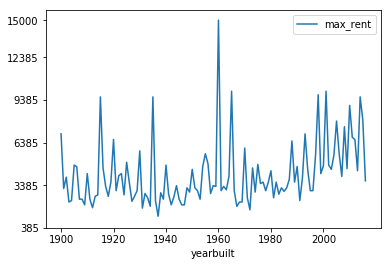

In [5]:
def displayRentPerYear(df):
    temp = pd.DataFrame()
    temp1 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('max').reset_index()
    temp[['yearbuilt','max_rent']] = temp1[['yearbuilt','rent']]
    temp1 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('min').reset_index()
    temp['min_rent'] = temp1['rent']
    temp1 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('mean').reset_index()
    temp['mean_rent'] = temp1['rent']
    #temp.plot.line('yearbuilt','rent')
    #temp.plot.line('yearbuilt','min_rent')
    temp.plot('yearbuilt',['min_rent','mean_rent'],xticks=(np.arange(df.yearbuilt.min(), df.yearbuilt.max()+1, 20)))
    temp.plot('yearbuilt','max_rent',xticks=(np.arange(df.yearbuilt.min(), df.yearbuilt.max()+1, 20)), yticks=y_ticks)
    fig, ax = plt.subplots()
    #ax.axhline(df['rent'].max(),color='r',lw=1)
    #ax.axvline(year,color='r',lw=1)
    ax.figure.text = 'Zoomed'
    ax.text(1960,int(temp.max_rent.max()),'Max Rent - '+str(temp.max_rent.max()))
    temp = temp[temp.yearbuilt > 1899]
    temp.plot('yearbuilt',['min_rent','mean_rent'],xticks=(np.arange(temp.yearbuilt.min(), temp.yearbuilt.max()+1, 20)))
    temp.plot('yearbuilt','max_rent',xticks=(np.arange(temp.yearbuilt.min(), temp.yearbuilt.max()+1, 20)), yticks=y_ticks)
    temp.plot('yearbuilt','max_rent',xticks=(np.arange(temp.yearbuilt.min(), temp.yearbuilt.max()+1, 10)), yticks=y_ticks,ax=ax,\
              legend=None,title="From 1900 - 2020")

displayRentPerYear(df)

##### Let us plot the rent pattern for property_type

C:\Users\padmaraj.bhat\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


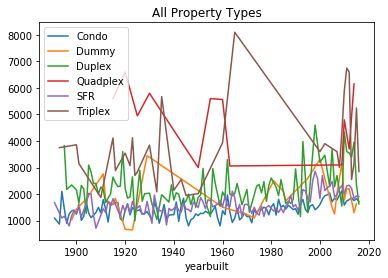

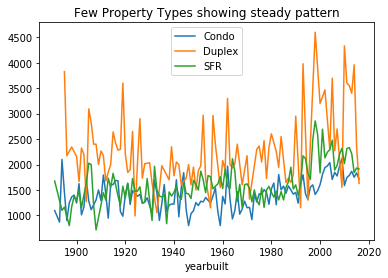

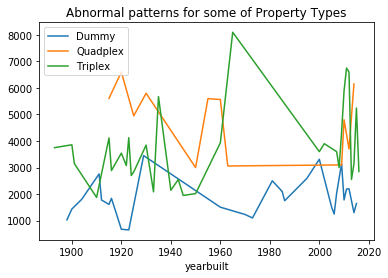

In [6]:
'''Condo                    15515 non-null int64
Duplex                   15515 non-null int64
Quadplex                 15515 non-null int64
SFR                      15515 non-null int64
Triplex   '''

def displayRentPerYearPerPropertyType():
    df = pd.read_csv(r'C:\Users\padmaraj.bhat\OneDrive - Accenture\Downloads\TrainData_PA.csv')
    temp = df[['yearbuilt','rent','property_type']]
    temp.property_type = temp.property_type.fillna('Dummy')
    
    #little bit of cleaning
    temp = temp[temp.yearbuilt > 1890]
    #temp = temp[temp.rent < temp.rent.max()]
    #print(temp.property_type.unique())
    
    temp1 = temp.groupby(['yearbuilt','property_type']).agg('mean').reset_index()
        
    #temp1.property_type = temp1.property_type.apply(lambda x : getcolor(x))
    fig, ax = plt.subplots()
    
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        ax = grp.plot(ax=ax, kind='line', x='yearbuilt', y='rent',label=key,title='All Property Types' )
    plt.show()
    
    fig, ax = plt.subplots()
    
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        if key in ['Condo','SFR','Duplex']:
            ax = grp.plot(ax=ax, kind='line', x='yearbuilt', y='rent',label=key, \
                          title = 'Few Property Types showing steady pattern' )
    plt.show()
    fig, ax = plt.subplots()
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        if key in ['Dummy','Quadplex','Triplex']:
            ax = grp.plot(ax=ax, kind='line', x='yearbuilt', y='rent',label=key,\
                         title='Abnormal patterns for some of Property Types')
    plt.show()

displayRentPerYearPerPropertyType()

In [7]:
list(df)

['rent',
 'cemetery_dist_miles',
 'nationalhighway_miles',
 'railline_miles',
 'starbucks_miles',
 'walmart_miles',
 'hospital_miles',
 'physician_dist_miles',
 'dentist_dist_miles',
 'opt_dist_miles',
 'vet_dist_miles',
 'farmers_miles',
 'bed',
 'bath',
 'halfbath',
 'sqft',
 'yearbuilt',
 'lotsize',
 'Census_MedianIncome',
 'CollegeGrads',
 'WhiteCollar',
 'Schools',
 'Unemployment',
 'EmploymentDiversity',
 'Census_Vacancy',
 'Crime_Rate',
 'HomePrice',
 'x',
 'y',
 'z',
 '2015.25',
 '2015.5',
 '2015.75',
 '2016.25',
 'Condo',
 'Duplex',
 'Quadplex',
 'SFR',
 'Triplex',
 'garage_no',
 'garage_yes',
 'pool_no',
 'pool_yes',
 'fireplace_no',
 'fireplace_yes',
 'patio_no',
 'patio_yes']

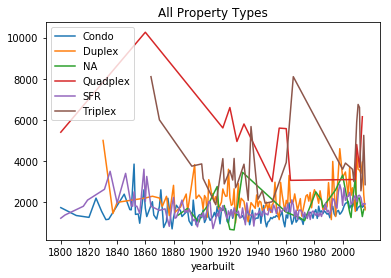

In [29]:
def getTheCleansedData():
    df = pd.read_csv(r'C:\Users\padmaraj.bhat\OneDrive - Accenture\Downloads\TrainData_PA.csv')
    df.property_type = df.property_type.fillna('NA')
    key_columns = [x for x in list(df) if x != 'time']
    df = df.sort_values(by='time', ascending=False)
    df = df.drop_duplicates(key_columns,keep='first')
    
    colorMap = {'Condo': 'red', 'SFR': 'green', 'Duplex': 'black', 'NA': 'blue', 'Quadplex': 'yellow', 'Triplex':'orange', }
    df['property_type_color_map'] = df.property_type.apply(lambda x : colorMap[x])
    
    return df
    
def test():
    df = getTheCleansedData()
    
    temp = df[['yearbuilt','property_type','rent']]
    temp1 = df.groupby(['property_type','yearbuilt']).agg('mean').reset_index()
        
    xticks = range(df.yearbuilt.min(),df.yearbuilt.max(),20)
    fig, ax = plt.subplots()
    
    for key, grp in temp1.groupby(['property_type']):
        #print(type(key))
        ax = grp.plot(ax=ax, kind='line', x='yearbuilt', y='rent',label=key,title='All Property Types', xticks=xticks )
    plt.show()
    
    return

test()

In [9]:
df[df.yearbuilt.isin(range(1820,1900))]

,rent,cemetery_dist_miles,nationalhighway_miles,railline_miles,starbucks_miles,walmart_miles,hospital_miles,physician_dist_miles,dentist_dist_miles,opt_dist_miles,...,SFR,Triplex,garage_no,garage_yes,pool_no,pool_yes,fireplace_no,fireplace_yes,patio_no,patio_yes
16,745,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,0,0,0,1,0,1,0,1,0,1
30,900,0.524611,0.003396,0.236825,12.853682,1.669538,0.597786,0.132604,0.399106,0.515384,...,0,0,0,1,0,1,0,1,0,1
62,1000,1.485993,0.099709,0.254928,0.838931,6.267078,0.221749,0.049569,0.134215,0.080816,...,0,0,0,1,0,1,0,1,0,1
150,1150,1.019586,0.206222,0.629888,1.348776,3.326397,1.584675,0.229126,0.472933,0.651244,...,1,0,0,1,0,1,1,0,0,1
160,1150,0.664965,0.156912,0.204725,1.852136,5.129625,1.285189,0.514206,0.247856,0.804154,...,0,0,0,1,0,1,0,1,0,1
246,1800,0.961199,0.063149,0.080259,0.904222,5.681614,0.852219,0.117031,0.246744,0.365394,...,1,0,0,1,0,1,0,1,0,1
358,975,1.380306,0.191951,0.201279,0.660927,5.165126,0.512900,0.435030,0.573868,0.435030,...,0,0,0,1,0,1,0,1,0,1
515,2900,0.938933,0.408940,0.256257,1.554612,3.380310,3.366576,0.311236,0.502649,0.410601,...,0,0,0,1,0,1,1,0,0,1
661,3250,0.828451,0.087538,0.163297,0.328493,6.066248,0.590183,0.092392,0.125948,0.102810,...,1,0,1,0,0,1,1,0,1,0
704,950,1.450656,0.015156,0.089141,0.534443,5.260674,0.281519,0.270054,0.384501,0.368280,...,1,0,0,1,0,1,0,1,0,1


C:\Users\padmaraj.bhat\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


rent                     1.000000
bath                     0.697033
bed                      0.567084
sqft                     0.423986
CollegeGrads             0.327992
WhiteCollar              0.324943
HomePrice                0.307455
Census_MedianIncome      0.231945
fireplace                0.199955
halfbath                 0.166411
zipcode                  0.149380
vet_dist_miles           0.129342
garage                   0.117934
starbucks_miles          0.110549
Census_Vacancy           0.072238
EmploymentDiversity      0.067369
farmers_miles            0.066874
hospital_miles           0.061187
Unemployment             0.060953
pool                     0.060580
yearbuilt                0.058772
latitude                 0.055222
patio                    0.045028
physician_dist_miles     0.039704
time                     0.037832
walmart_miles            0.036871
longitude                0.035929
Crime_Rate               0.034368
Schools                  0.030688
dentist_dist_m

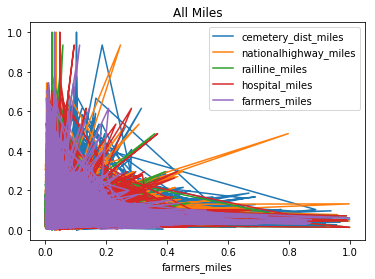

hospital_miles           1.000000
railline_miles           0.649964
dentist_dist_miles       0.646585
physician_dist_miles     0.618823
opt_dist_miles           0.613787
farmers_miles            0.594129
cemetery_dist_miles      0.531317
starbucks_miles          0.522016
nationalhighway_miles    0.438850
walmart_miles            0.404961
vet_dist_miles           0.312193
Schools                  0.264697
lotsize                  0.252692
Census_Vacancy           0.249568
fireplace                0.202730
Crime_Rate               0.196073
Census_MedianIncome      0.185391
EmploymentDiversity      0.161352
garage                   0.160271
yearbuilt                0.116377
Unemployment             0.101341
CollegeGrads             0.098383
latitude                 0.093433
WhiteCollar              0.091591
time                     0.086768
sqft                     0.081589
pool                     0.066036
rent                     0.061187
zipcode                  0.049942
bath          

In [10]:

def rentMiles():
    df = getTheCleansedData()
    #print(list(df))
    '''miles_columns = ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', \
                     'starbucks_miles', 'walmart_miles', 'hospital_miles', 'physician_dist_miles', \
                     'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', 'farmers_miles']'''
    
    miles_columns = ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', \
                     'hospital_miles', \
                      'farmers_miles']
    df1 = df[miles_columns]
    df1['rent'] = df['rent']
    df1 = df1.reset_index()
    print(df.corr().abs()['rent'].sort_values(ascending=False))
    
    '''s = c.unstack()
    so = s.sort_values(kind="quicksort")
    #df_temp = pd.DataFrame(so)
    print(so[-60:])'''
    
    min_max_scaler = preprocessing.MinMaxScaler()
    np_scaled = min_max_scaler.fit_transform(df1)
    df_normalized = pd.DataFrame(np_scaled,columns=df1.columns)
    
    fig, ax = plt.subplots()
    for c in miles_columns:
        ax = df_normalized.plot(ax=ax, kind='line', x=c, y='rent',label=c,title='All Miles' )
    plt.show()
    print(df.corr().abs()['hospital_miles'].sort_values(ascending=False))
rentMiles() 

In [11]:
def corrPrint():
    df = getTheCleansedData()
    df_corr = df.corr().abs()
    for c in list(df_corr):
        print(df_corr[c].sort_values(ascending = False)[:5])
        
corrPrint()    

zipcode                1.000000
longitude              0.228522
vet_dist_miles         0.166061
Census_MedianIncome    0.156508
rent                   0.149380
Name: zipcode, dtype: float64
rent            1.000000
bath            0.697033
bed             0.567084
sqft            0.423986
CollegeGrads    0.327992
Name: rent, dtype: float64
latitude           1.000000
longitude          0.283620
vet_dist_miles     0.106568
farmers_miles      0.099108
starbucks_miles    0.096622
Name: latitude, dtype: float64
longitude         1.000000
latitude          0.283620
zipcode           0.228522
Census_Vacancy    0.094195
patio             0.069810
Name: longitude, dtype: float64
cemetery_dist_miles     1.000000
hospital_miles          0.531317
dentist_dist_miles      0.445907
physician_dist_miles    0.432330
railline_miles          0.421692
Name: cemetery_dist_miles, dtype: float64
nationalhighway_miles    1.000000
physician_dist_miles     0.515508
opt_dist_miles           0.504211
dentist_dis

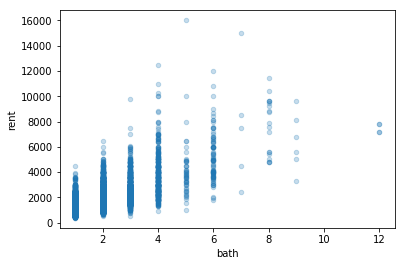

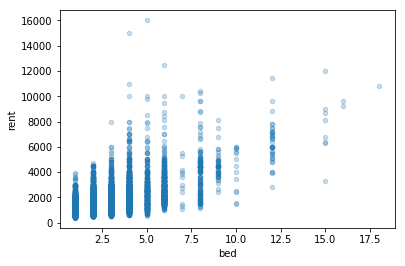

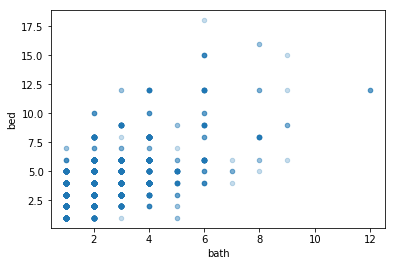

In [13]:
def rentVsBathBed():
    df = getTheCleansedData()
    df.plot.scatter('bath','rent',alpha=.25)
    df.plot.scatter('bed','rent',alpha=.25)
    df.plot.scatter('bath','bed',alpha=.25)
rentVsBathBed()

Let us see what is yearbuilt in when railwaylines are far


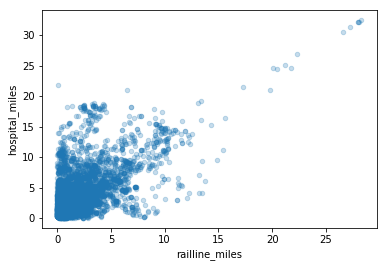

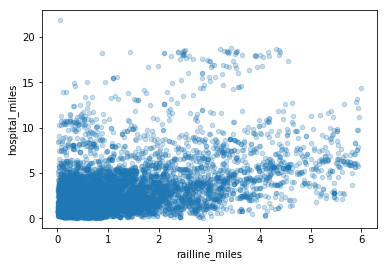

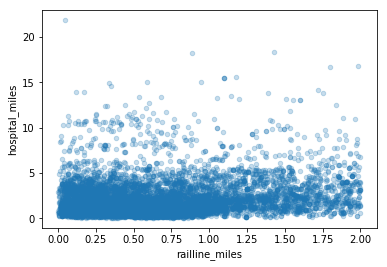

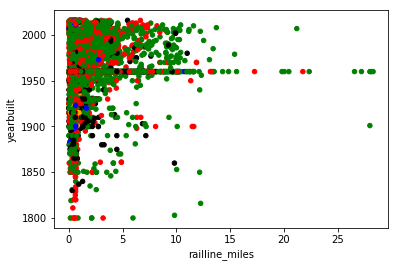

In [31]:
def railwayVsHospital():
    df =getTheCleansedData()
    df.plot.scatter('railline_miles','hospital_miles', alpha = .25)
    
    temp = df[df.railline_miles <6]
    temp.plot.scatter('railline_miles','hospital_miles', alpha = .25)
    
    temp = df[df.railline_miles <2]
    temp.plot.scatter('railline_miles','hospital_miles', alpha = .25)
    
    print("Let us see what is yearbuilt in when railwaylines are far")
    #df[df.railline_miles > 5].plot.scatter('railline_miles','yearbuilt')
    list1= list(df.property_type_color_map)
    df.plot.scatter('railline_miles','yearbuilt',c=list1)
railwayVsHospital()

##### In all the years people always targetted to be near raillines. It is been a trend that usually only SFR property are away from raillines. May be they like quiet places.

In [15]:
def numPropertyPerYear():
    df = getTheCleansedData()
    print(Counter(df[df.railline_miles > 10].property_type))
    print(Counter(df[df.railline_miles <= 10].property_type))
    print(df[['property_type','lotsize','railline_miles']].groupby('property_type').agg('mean').reset_index())
    print(df[['property_type','lotsize','railline_miles']][df.railline_miles > 10].groupby('property_type').agg('mean').reset_index())
    print(df[['property_type','lotsize','railline_miles']][df.railline_miles <= 10].groupby('property_type').agg('mean').reset_index())
numPropertyPerYear()

Counter({'SFR': 65, 'Condo': 11, 'Duplex': 5, 'NA': 1})
Counter({'Condo': 7354, 'SFR': 6003, 'NA': 2685, 'Duplex': 1638, 'Triplex': 238, 'Quadplex': 80})
  property_type      lotsize  railline_miles
0         Condo  3215.115589        0.842856
1        Duplex  4156.721992        0.929850
2            NA  3223.630566        0.756152
3      Quadplex  2150.908333        0.612393
4           SFR  4402.934296        1.467670
5       Triplex  2074.841332        0.485334
  property_type      lotsize  railline_miles
0         Condo  3975.434749       12.801362
1        Duplex  6102.158984       11.242997
2            NA  2872.730796       10.783933
3           SFR  5373.951103       13.662306
  property_type      lotsize  railline_miles
0         Condo  3213.978315        0.824968
1        Duplex  4150.783540        0.898369
2            NA  3223.761255        0.752417
3      Quadplex  2150.908333        0.612393
4           SFR  4392.420204        1.335627
5       Triplex  2074.841332        

##### Property which are away from raillines does have bigger lotsize. They are also mostly Single Family Residentials (SFR).
https://www.movoto.com/foundation/real-estate-concepts/property-type-sfr-what-is-it-and-what-does-it-mean-for-zoning/

   yearbuilt  rent
0       1800    12
1       1803     1
2       1811     1
3       1816     1
4       1819     1


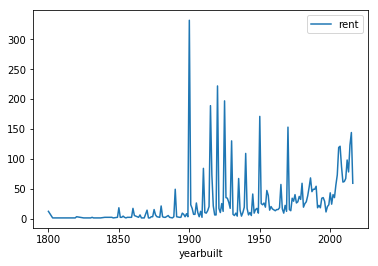

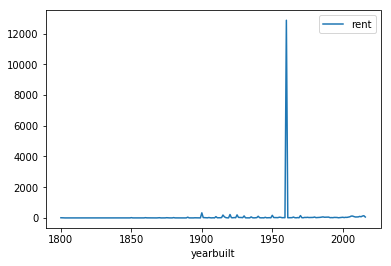

In [16]:
def numPropertyPerYear():
    x=y=[]
    df = getTheCleansedData()
    df2 = df[['yearbuilt','rent']].groupby('yearbuilt').agg('count').reset_index()
    print(df2.head())
    df2[df2.yearbuilt != 1960].plot('yearbuilt','rent')
    df2.plot('yearbuilt','rent')
    
    #df2.plot(legend=None)
    #print(df2)
numPropertyPerYear()

##### There has been peak of house construction during 1900 and 1960
* http://statemuseumpa.org/levittown/one/b.html
* https://www.thoughtco.com/the-post-war-us-economy-1945-to-1960-1148153
* https://www.theatlantic.com/business/archive/2015/09/the-post-war-american-home/407227/

C:\Users\padmaraj.bhat\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


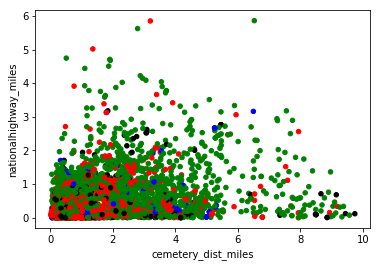

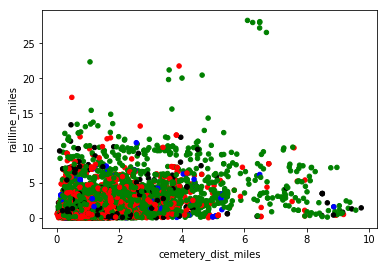

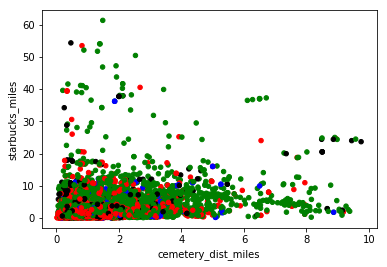

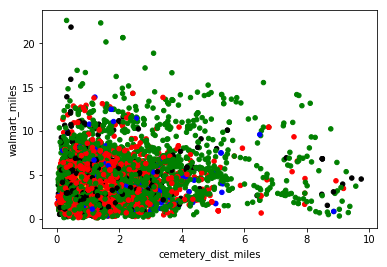

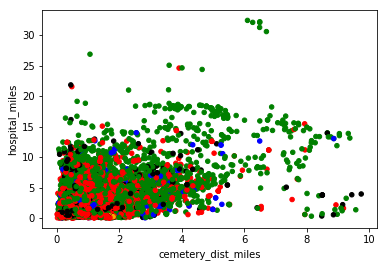

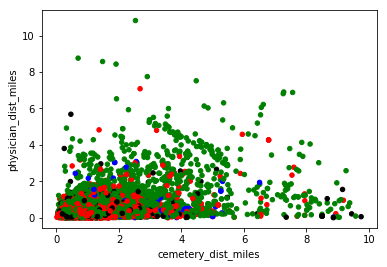

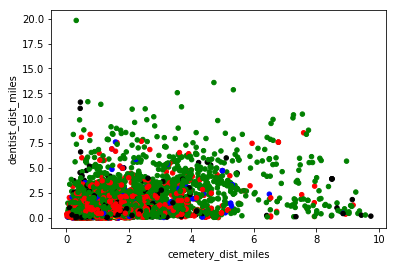

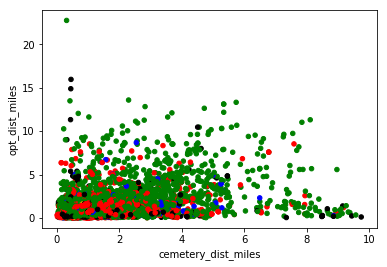

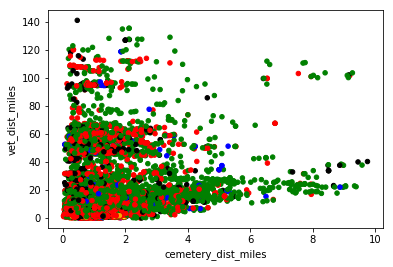

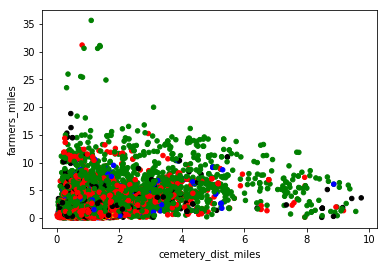

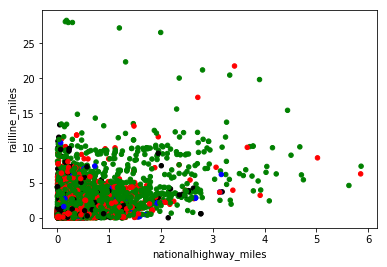

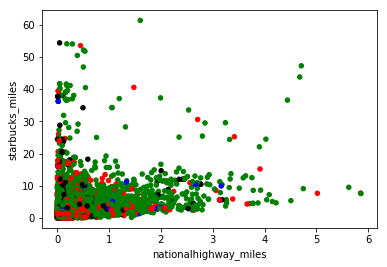

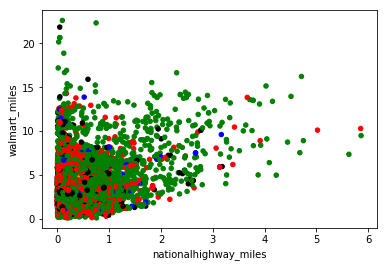

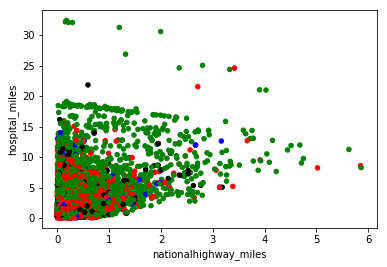

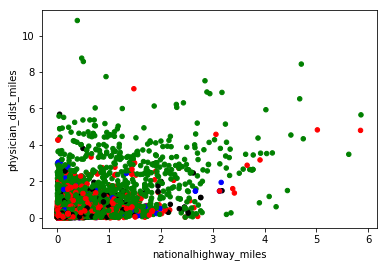

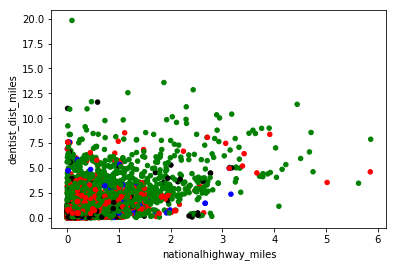

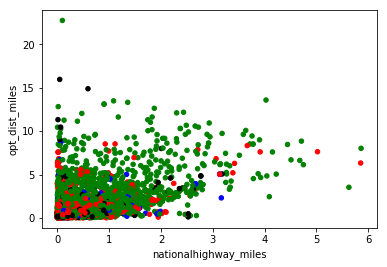

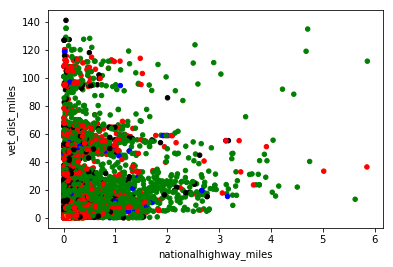

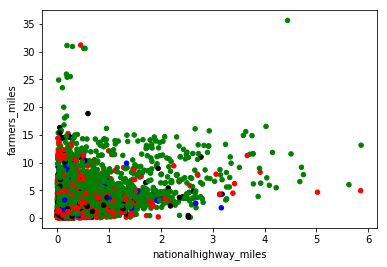

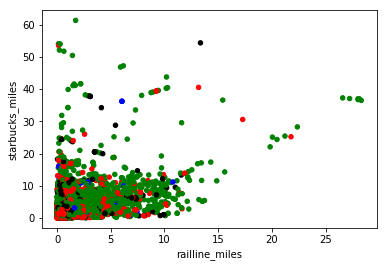

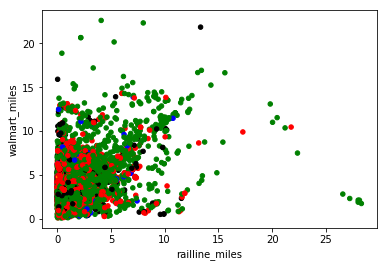

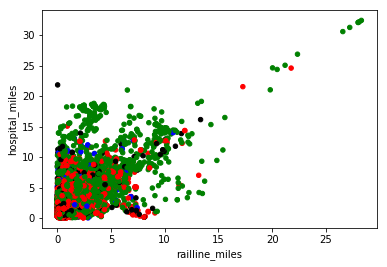

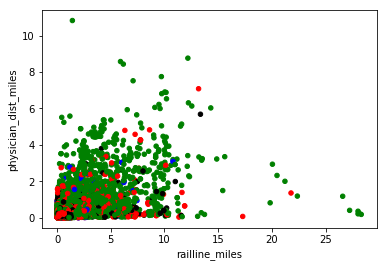

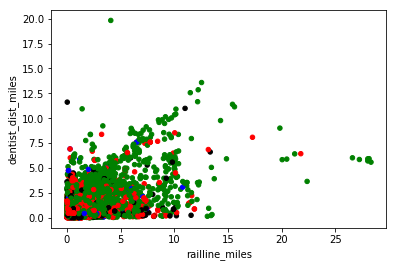

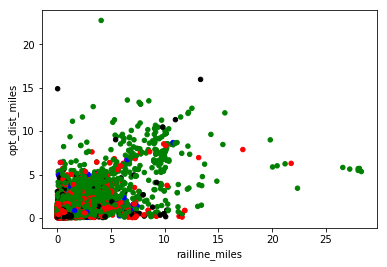

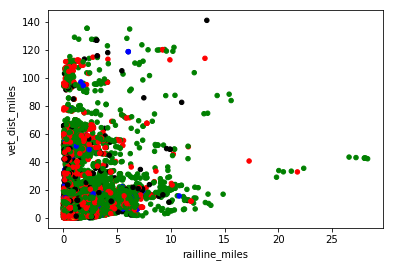

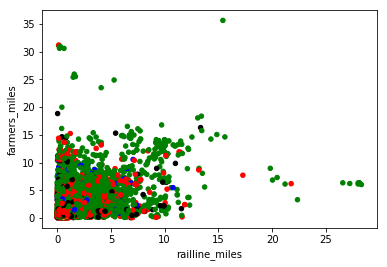

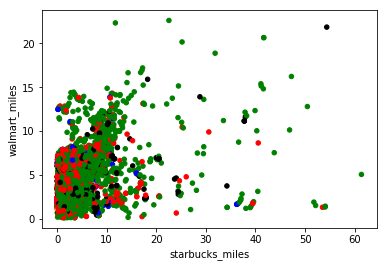

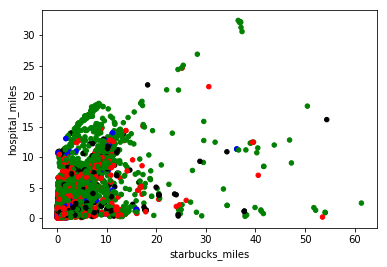

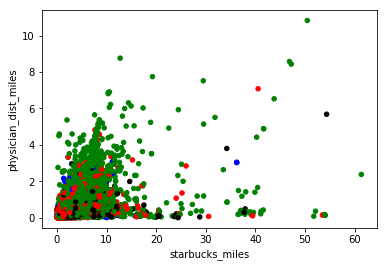

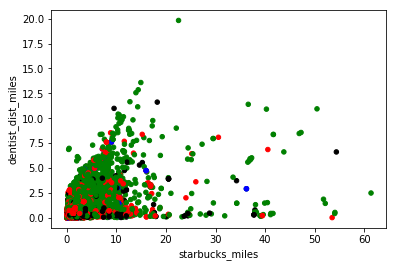

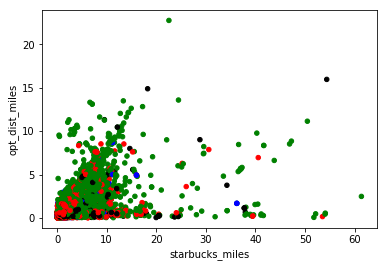

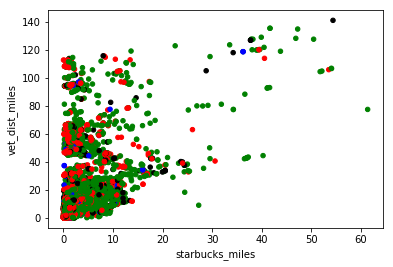

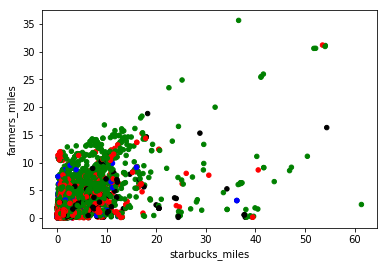

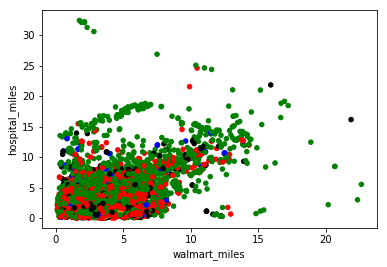

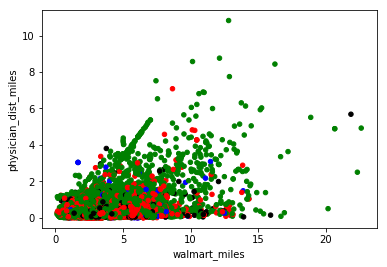

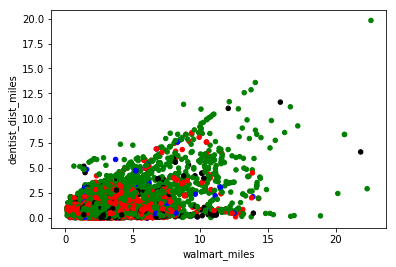

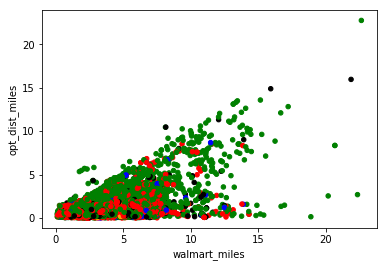

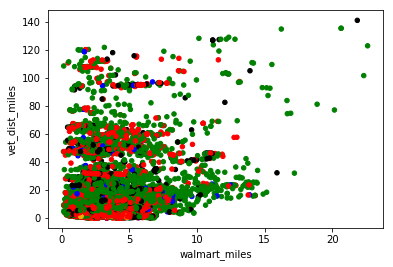

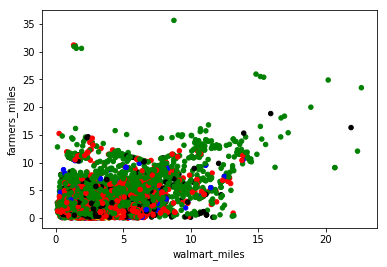

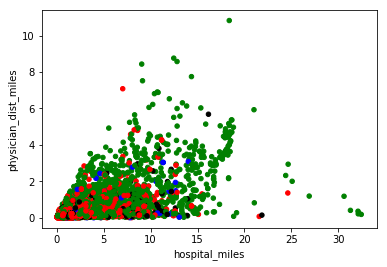

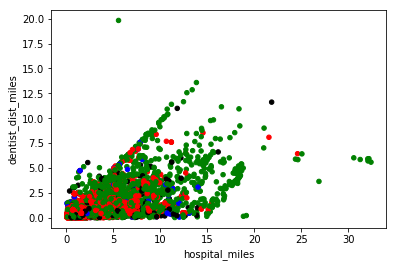

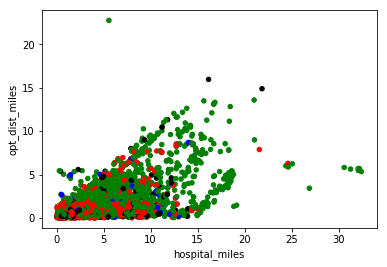

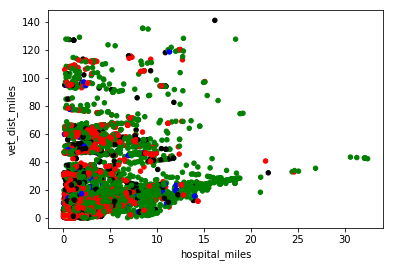

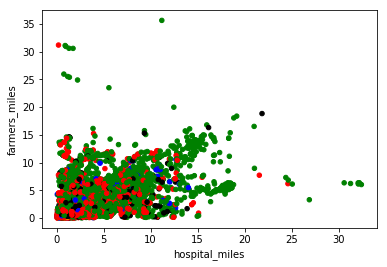

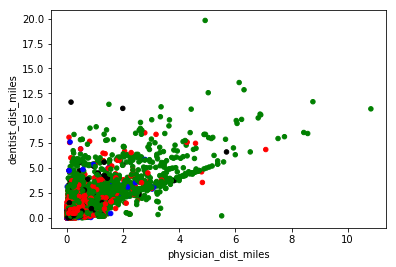

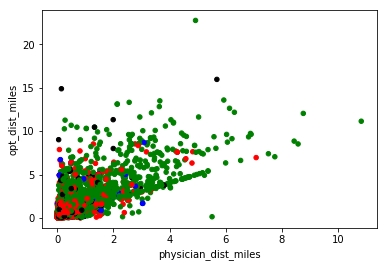

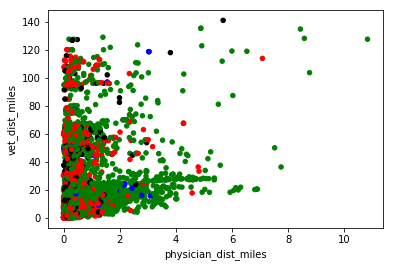

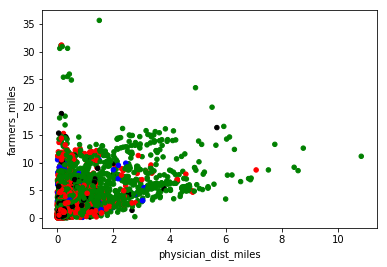

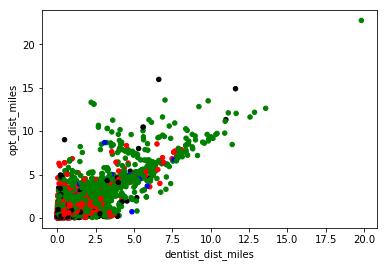

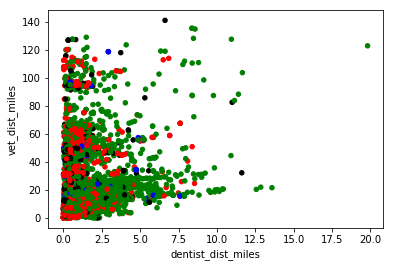

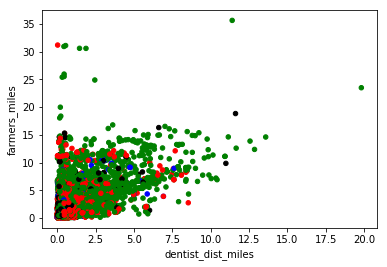

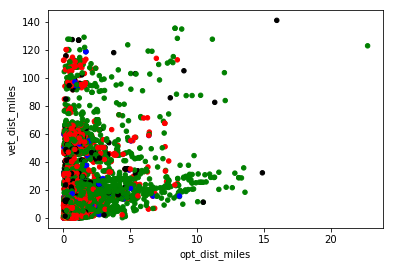

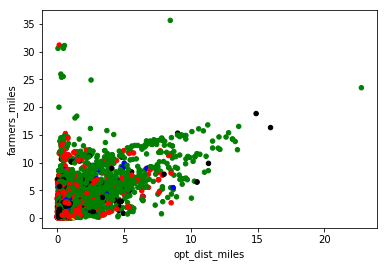

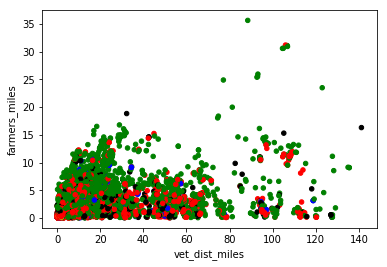

In [33]:
def milesPlot():
    df = getTheCleansedData()
    #miles_list = ['hospital_miles','railline_miles', 'dentist_dist_miles', 'physician_dist_miles', 'opt_dist_miles']
    miles_list = ['cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', 'starbucks_miles', 'walmart_miles', \
                  'hospital_miles', 'physician_dist_miles', 'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', \
                  'farmers_miles']
    
    #colorMap = {'Condo': 0, 'SFR': 1, 'Duplex': 2, 'NA': 3, 'Quadplex': 4, 'Triplex':5, }
    colorMap = {'Condo': 'red', 'SFR': 'green', 'Duplex': 'black', 'NA': 'blue', 'Quadplex': 'yellow', 'Triplex':'orange', }
    df['property_type_color_map'] = df.property_type.apply(lambda x : colorMap[x])
    list1 = list(df.property_type_color_map)
    #df.property_type_color_map = df.property_type_color_map.astype('category')
    
    already_plotted = []
    for d in miles_list:
        for c in miles_list:
            if d != c:
                if (c,d) not in already_plotted:
                    already_plotted.append((d,c))
                    df.plot.scatter(d,c,c=list1, legend='property_type')#,colormap='viridis')
milesPlot()

In [34]:
def dummy():
    df = getTheCleansedData()
    print(list(df))
    
dummy()

['county', 'city', 'zipcode', 'address', 'state', 'rent', 'latitude', 'longitude', 'cemetery_dist_miles', 'nationalhighway_miles', 'railline_miles', 'starbucks_miles', 'walmart_miles', 'hospital_miles', 'physician_dist_miles', 'dentist_dist_miles', 'opt_dist_miles', 'vet_dist_miles', 'farmers_miles', 'time', 'bed', 'bath', 'halfbath', 'sqft', 'property_type', 'garage', 'yearbuilt', 'pool', 'fireplace', 'patio', 'lotsize', 'Census_MedianIncome', 'CollegeGrads', 'WhiteCollar', 'Schools', 'Unemployment', 'EmploymentDiversity', 'Census_Vacancy', 'Crime_Rate', 'HomePrice', 'property_type_color_map']
